In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy
import cartopy
import cartopy.crs as ccrs

# NivaPy mapping demo

Quick overview of some of the mapping functions available in NivaPy as of December 2017.

## 1. Connect to RESA2 database

In [2]:
# Connect to db
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


## 2. Query projects

The code below queries the RESA2 database to identify the project number for the 1995 "1000 lakes survey".

In [3]:
# Search projects
prj_df = nivapy.da.search_projects("project_name LIKE 'Regional%'", ora_eng)
prj_df

,project_id,project_number,project_name,contact_person,project_description
0,27,None,Regionalundersøkelse 1995,RESA,Tusensjøersundersøkelsen 1995 med etterfølgend...
1,81,None,Regionalundersøkelse 1986,None,Tusensjøers undersøkelsen 1986 samt nyere data...


The project we're interested has `project_id=27`.

## 3. Get stations

Next, get the stations associated with the project of interest.

In [4]:
# Get stations for 1995 survey
stn_df = nivapy.da.select_project_stations([27,], ora_eng)

print 'Number of stations:', len(stn_df)
stn_df.head()

Number of stations: 1006


,station_id,station_code,station_name,latitude,longitude,altitude
0,115,831-501,BrÃ¥rvatn,59.294921,7.727118,902.0
1,116,1640-603,Tufsingen,62.612294,11.876558,781.0
2,125,2030-607,St.Valvatnet,69.694975,30.656211,157.0
3,135,1228-501,Steinavatn,59.859877,6.578783,1047.0
4,166,1018-4,Kleivsetvannet,58.119559,7.664899,93.0


## 4. Quick "interactive" map of station locations

For a quick overview of the data, `nivapy.spatial.quickmap()` can be used directly with the results returned from the database.

In [5]:
# Add station locs from RESA2
map1 = nivapy.spatial.quickmap(stn_df)
map1

## 5. Get water chemistry data

Next, extract 1995 water chemsitry data for all 1006 sites. It is possible to query multiple parameters at once, but here I'll just focus on pH. Having extracted the data from the database, the code calculates the average concentration in each lake during 1995.

In [6]:
# Pars of interest
par_list = ['pH',]

# Container for results
df_list = []

# Loop over stations
for stn_id in stn_df['station_id']:
    # Get all Al data
    wc_df, dup_df = nivapy.da.extract_water_chem(stn_id, 
                                                 par_list,
                                                 '1995-01-01', 
                                                 '1995-12-31',
                                                 ora_eng,
                                                 plot=False)
    
    # Tidy
    wc_df['station_id'] = stn_id
    wc_df.reset_index(inplace=True)
    df_list.append(wc_df)  

# Combine output
wc_df = pd.concat(df_list, axis=0)

#  Annual means for each site
wc_df = wc_df.groupby('station_id').mean()

# Ignore LOD flags
cols = [i for i in wc_df.columns if i.split('_')[1] != 'flag']
wc_df = wc_df[cols]
wc_df.reset_index(inplace=True)

# Join station details and drop any with missing co-ords
wc_df = pd.merge(stn_df[['station_id', 'latitude', 'longitude']],
                 wc_df, 
                 how='left', 
                 on='station_id')
wc_df.dropna(subset=['latitude', 'longitude'], inplace=True)

wc_df.head()

,station_id,latitude,longitude,pH_None
0,115,59.294921,7.727118,5.79
1,116,62.612294,11.876558,6.48
2,125,69.694975,30.656211,6.44
3,135,59.859877,6.578783,5.11
4,166,58.119559,7.664899,5.00


## 6. Static map of points for reports/publications

The function `nivapy.spatial.plot_norway_point_data()` is specifically designed for quickly producing **national scale** maps of Norway using an Albers Equal Area projection. Much more sophisticated maps are possible, but this function offers a simple interface and may be suitable for reports etc.

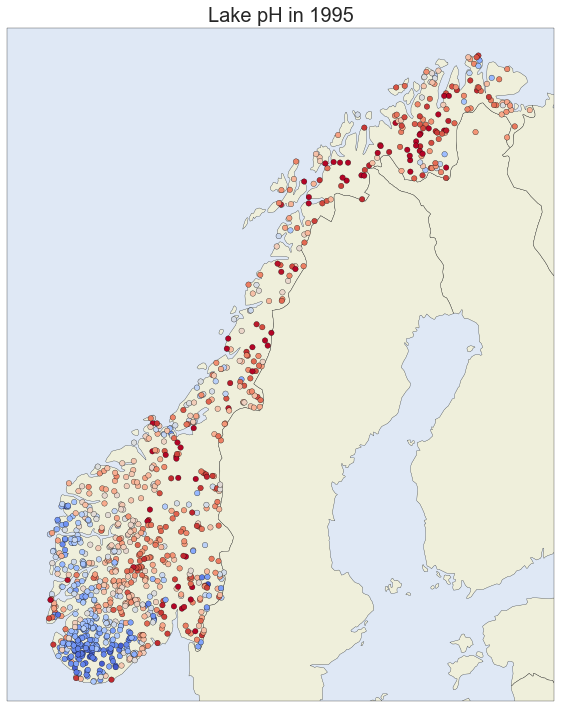

In [7]:
# Path to save
out_png = r'C:\Data\James_Work\NivaPy\images\ph_1995.png'

# Map
nivapy.spatial.plot_norway_point_data(wc_df, 
                                      par='pH_None', 
                                      title='Lake pH in 1995',
                                      out_path=out_png)

## 7. Spatial interpolation

NivaPy also offers functions for spatial interpolation using [Inverse Distance Weighting (IDW)](https://en.wikipedia.org/wiki/Inverse_distance_weighting), cubic splines or a bi-linear algorithm. The example here uses IDW.

First, we interpolate the point data onto a 1 km grid.

In [8]:
# Cell size (metres)
cell_size = 1000

# Define co-ord system
crs = ccrs.AlbersEqualArea(central_longitude=15, 
                           central_latitude=65, 
                           false_easting=650000, 
                           false_northing=800000,
                           standard_parallels=(55, 75)) 

# Extent in metres for map proj
xmin, xmax, ymin, ymax = (0, 1300000, 0, 1600000)

# Setup grid for interpolation (shift by (cell_size/2) s.t. values 
# are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size/2.)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size/2.)

# Get data
idw_df = wc_df[['latitude', 'longitude', 'pH_None']].dropna(how='any')  

# Map (long, lat) to projected (x, y)
pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                           x=idw_df['longitude'].values, 
                           y=idw_df['latitude'].values)[:, :2]

# Get values to interpolate
vals = idw_df['pH_None'].values

# IDW interpolation (using default n=8 and p=2)
idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy)

idw

array([[ 5.5585956 ,  5.55854811,  5.55850036, ...,  6.05394993,
         6.05394996,  6.05395   ],
       [ 5.73744336,  5.73743919,  5.55847536, ...,  6.0539461 ,
         6.05394614,  6.05394619],
       [ 5.73729208,  5.73728521,  5.73727923, ...,  6.05394226,
         6.05394232,  6.05394237],
       ..., 
       [ 6.69093124,  6.69092767,  6.69092407, ...,  6.27507368,
         6.27502366,  6.27497341],
       [ 6.69091874,  6.69091514,  6.69091152, ...,  6.27494381,
         6.27489498,  6.2748459 ],
       [ 6.69090626,  6.69090264,  6.690899  , ...,  6.27481482,
         6.27476715,  6.27471923]])

Having estimated an array of interpolated values, we can plot the results using `nivapy.spatial.plot_norway_raster_data()`. As with `plot_norway_point_data()`, this is just a rough convenience function for visualising and saving national scale raster maps. For complete control, you can use [Cartopy](http://scitools.org.uk/cartopy/) directly, but the function here provides a quick interface for the basics.

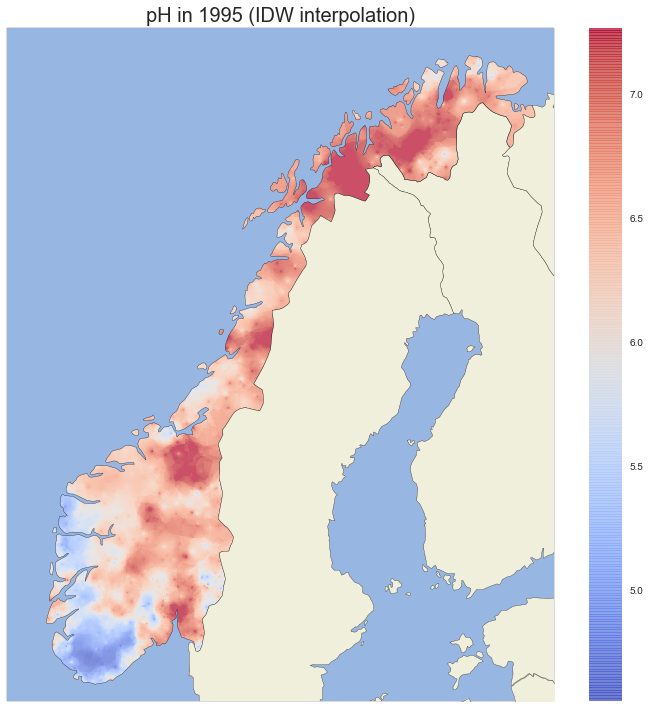

In [9]:
# Path to save
out_png = r'C:\Data\James_Work\NivaPy\images\ph_1995_idw_interp.png'

# Plot
nivapy.spatial.plot_norway_raster_data(idw, 
                                       vmax_pct=0.99, 
                                       cmap='coolwarm', 
                                       title='pH in 1995 (IDW interpolation)', 
                                       out_path=out_png)

With a bit more work, much more complex grid plots are possible - see e.g. the examples [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_metals_3.ipynb#2.-Spatially-interpolate-moss-data).